{download}`Download this notebook <1_algebraic_connectivity.ipynb>`

## Spectral optimization (alebraic congnectivity)
> **Main `gradnet` concepts demonstrated below**
> - Configuring a `GradNet` model for network optimization
> - Custom **loss function**
> - Training the network structure using `fit`
> - Accelerator selection (**cpu/gpu**)
> - **Learning rate** selection
> - Extracting and visualizing the optimized networks
> - Converting to **NetworkX**
> - Using a **mask** to ignore forbidden edges (e.g., grid)  

### Problem setup
The second Laplacian eigenvalue is a quantitative measure of connectivity and robustness. It indicates how “tightly held together” a network is, governs how fast diffusion converges on it, and reveals natural partitions in its structure.

### GradNet optimization

In [88]:
from gradnet import GradNet
from gradnet.trainer import fit
import torch
from matplotlib import pyplot as plt
from gradnet.utils import plot_adjacency_heatmap, plot_graph
import tensorboard


N = 50
budget_per_node = 1.0

gn = GradNet(num_nodes=N, budget=budget_per_node*N, rand_init_weights=True)

# define the loss function
def loss_fn(gn):
    A = gn()  # get the adjacency matrix
    L = torch.diag(A.sum(dim=1)) - A  # compute the graph Laplacian
    eigs = torch.linalg.eigvalsh(L)  # compute the eigenvalues
    l2 = eigs[1]  # second smallest eigenvalue (algebraic connectivity)
    # loss is (1-λ₂), so minimizing it maximizes λ₂. 
    return 1-l2  # return loss, and also λ₂ as a metric

lightning_trainer, best_ckpt = fit(gn=gn, loss_fn=loss_fn, num_updates=10000, optim_kwargs={"lr": 0.001}, accelerator="cpu");



GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Updates:   0%|          | 0/10000 [00:00<?, ?it/s]


  | Name | Type    | Params | Mode 
-----------------------------------------
0 | gn   | GradNet | 2.5 K  | train
-----------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=10000` reached.


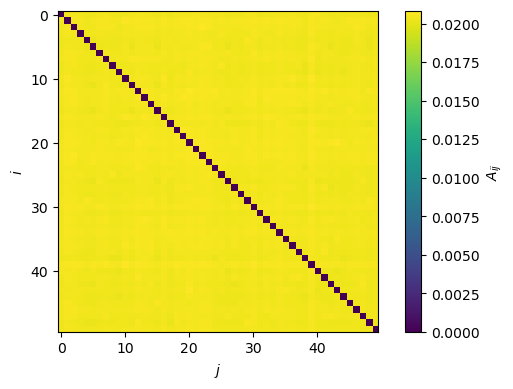

In [142]:
fig, ax = plt.subplots(figsize=(6, 4))
# ax2 = fig.add_subplot((.42,.47,.35,.5))
plot_adjacency_heatmap(gn, ax=ax)
# plot_graph(gn, ax=ax2)
plt.tight_layout()

We find that the uniform, completely connected graph is the optimal pattern for minimizing the resistance distance of the network.

### Restricting tunable edges to a grid

In [40]:
import numpy as np
import networkx as nx

rows = 25
cols = 30
N = rows * cols

def make_grid_mask(rows, cols):
    mask_nx = nx.grid_2d_graph(rows, cols)  # Build grid graph (nodes are (r, c) tuples)
    nodes = sorted(mask_nx.nodes())  # sort nodes
    return nx.to_numpy_array(mask_nx, nodelist=nodes)

mask = make_grid_mask(rows, cols)

gn_grid = GradNet(num_nodes=N, budget=budget_per_node * N, mask=mask, rand_init_weights=0.)
lightning_trainer, best_ckpt = fit(gn=gn_grid, loss_fn=loss_fn, num_updates=300, optim_kwargs={"lr": 0.01}, accelerator="cpu");

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Updates:   0%|          | 0/300 [00:00<?, ?it/s]


  | Name | Type    | Params | Mode 
-----------------------------------------
0 | gn   | GradNet | 562 K  | train
-----------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=300` reached.


/var/folders/72/79vqt54j447byqmvb80g_n3w0000gn/T/ipykernel_21495/995587147.py:15: DeprecationWarning:

`alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.



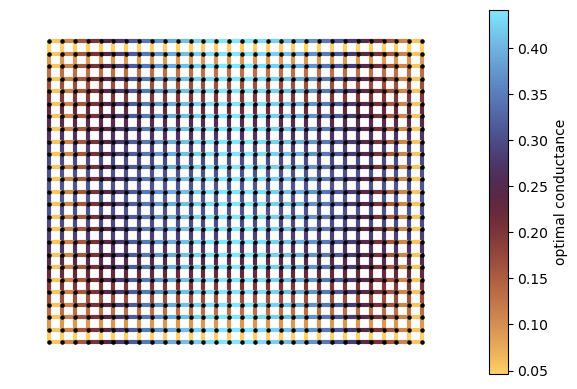

In [80]:
from gradnet.utils import to_networkx
import cmcrameri.cm as cmc


net = to_networkx(gn_grid)

def draw_grid_graph(net):
    """Draw a grid graph with edges colored by their weights."""
    edge_weights = np.array(list(nx.get_edge_attributes(net, 'weight').values()))
    pos = {r * cols + c: (c, -r) for r in range(rows) for c in range(cols)}

    fig, ax = plt.subplots(figsize=(6, 4))  # Create figure and axis
    cmap = cmc.managua
    # Draw graph on the same axis
    nx.draw_networkx_edges(net, pos=pos, ax=ax, edge_color=edge_weights, edge_cmap=cmap, width=3)
    nx.draw_networkx_nodes(net, pos=pos, ax=ax, nodelist=sorted(net.nodes()), node_color="k", node_size=5)
    ax.set_axis_off()

    # Add colorbar linked to edges
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array(edge_weights)
    fig.colorbar(sm, ax=ax, label="optimal conductance")

draw_grid_graph(net)
plt.tight_layout()
plt.show()

This indicates that, on a grid, edges near the center play a critical role and should be prioritized with more resources to enhance Algebraic Connectivity. At the periphery, edges matter differently: those aligned transversely to the boundary are significant, while those perpendicular to it contribute little importance.

/var/folders/72/79vqt54j447byqmvb80g_n3w0000gn/T/ipykernel_21495/1835234543.py:21: DeprecationWarning:

`alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.

/var/folders/72/79vqt54j447byqmvb80g_n3w0000gn/T/ipykernel_21495/1835234543.py:34: DeprecationWarning:

`alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.



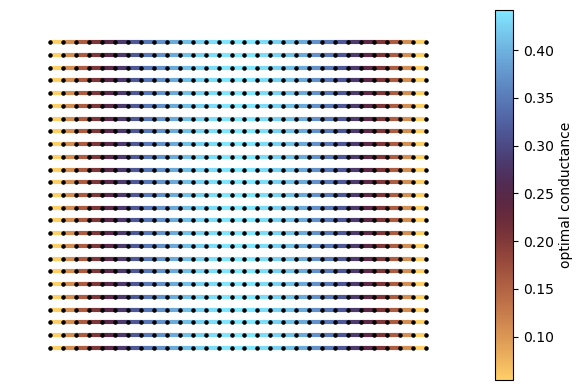

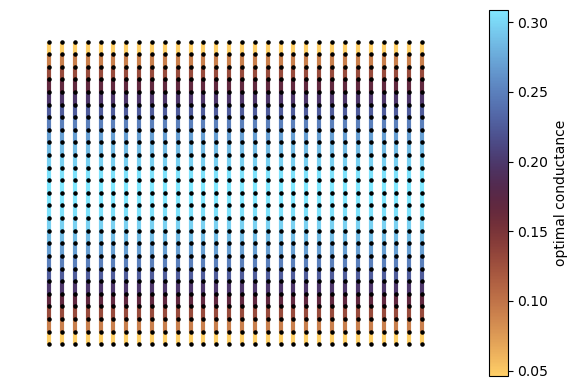

In [85]:
# Plot horizontal-only and vertical-only edges on the grid
# Assumes `net`, `rows`, `cols` defined above, and imports for numpy as np, networkx as nx, plt, and cmcrameri.cm as cmc

# Build 2D positions for each node index
pos = {r * cols + c: (c, -r) for r in range(rows) for c in range(cols)}

# Split edges into horizontal and vertical subsets
edges_all = list(net.edges())
edges_horiz = [(u, v) for (u, v) in edges_all if (u // cols == v // cols) and (abs(u - v) == 1)]
edges_vert = [(u, v) for (u, v) in edges_all if abs(u - v) == cols]

# Prepare weights for coloring
w_horiz = np.array([net[u][v]['weight'] for (u, v) in edges_horiz]) if len(edges_horiz) > 0 else np.array([])
w_vert = np.array([net[u][v]['weight'] for (u, v) in edges_vert]) if len(edges_vert) > 0 else np.array([])

cmap = cmc.managua

# Horizontal edges only
fig, ax = plt.subplots(figsize=(6, 4))
if len(edges_horiz) > 0:
    nx.draw_networkx_edges(net, pos=pos, ax=ax, edgelist=edges_horiz, edge_color=w_horiz, edge_cmap=cmap, width=3)
nx.draw_networkx_nodes(net, pos=pos, ax=ax, nodelist=sorted(net.nodes()), node_color="k", node_size=5)

plt.tight_layout()
ax.set_axis_off()
if len(edges_horiz) > 0:
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array(w_horiz)
    fig.colorbar(sm, ax=ax, label="optimal conductance")

# Vertical edges only
fig, ax = plt.subplots(figsize=(6, 4))
if len(edges_vert) > 0:
    nx.draw_networkx_edges(net, pos=pos, ax=ax, edgelist=edges_vert, edge_color=w_vert, edge_cmap=cmap, width=3)
nx.draw_networkx_nodes(net, pos=pos, ax=ax, nodelist=sorted(net.nodes()), node_color="k", node_size=5)
ax.set_axis_off()
if len(edges_vert) > 0:
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array(w_vert)
    fig.colorbar(sm, ax=ax, label="optimal conductance")

plt.tight_layout()
plt.show()


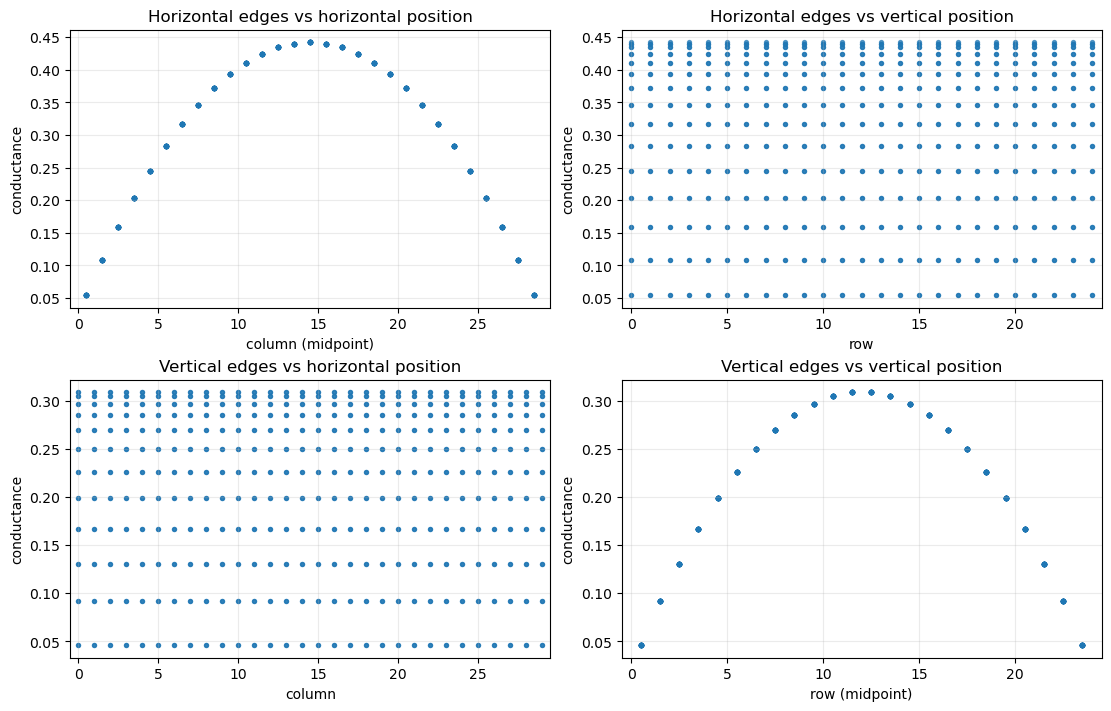

In [55]:
# One figure with 4 subplots: conductance vs position
# Top row: horizontal edges; Bottom row: vertical edges.
# Left column: x = horizontal (column) position; Right column: x = vertical (row) position.

def _rc(n):
    r = n // cols
    c = n % cols
    return r, c

# Build arrays for plotting
xh_hpos, xh_vpos, wh = [], [], []
for (u, v) in edges_horiz:
    ru, cu = _rc(u)
    rv, cv = _rc(v)
    r = ru  # same row
    c = min(cu, cv)
    xh_hpos.append(c + 0.5)       # horizontal midpoint between columns
    xh_vpos.append(r)             # row index
    wh.append(net[u][v]['weight'])

xv_hpos, xv_vpos, wv = [], [], []
for (u, v) in edges_vert:
    ru, cu = _rc(u)
    rv, cv = _rc(v)
    r = min(ru, rv)
    c = cu  # same column
    xv_hpos.append(c)             # column index
    xv_vpos.append(r + 0.5)       # vertical midpoint between rows
    wv.append(net[u][v]['weight'])

fig, axs = plt.subplots(2, 2, figsize=(11, 7), constrained_layout=True)

# Horizontal edges vs horizontal position
ax = axs[0, 0]
if len(wh) > 0:
    ax.scatter(xh_hpos, wh, s=8, alpha=0.7)
ax.set_title('Horizontal edges vs horizontal position')
ax.set_xlabel('column (midpoint)')
ax.set_ylabel('conductance')
ax.set_xlim(-0.5, cols - 0.5)
ax.grid(True, alpha=0.25)

# Horizontal edges vs vertical position
ax = axs[0, 1]
if len(wh) > 0:
    ax.scatter(xh_vpos, wh, s=8, alpha=0.7)
ax.set_title('Horizontal edges vs vertical position')
ax.set_xlabel('row')
ax.set_ylabel('conductance')
ax.set_xlim(-0.5, rows - 0.5)
ax.grid(True, alpha=0.25)

# Vertical edges vs horizontal position
ax = axs[1, 0]
if len(wv) > 0:
    ax.scatter(xv_hpos, wv, s=8, alpha=0.7)
ax.set_title('Vertical edges vs horizontal position')
ax.set_xlabel('column')
ax.set_ylabel('conductance')
ax.set_xlim(-0.5, cols - 0.5)
ax.grid(True, alpha=0.25)

# Vertical edges vs vertical position
ax = axs[1, 1]
if len(wv) > 0:
    ax.scatter(xv_vpos, wv, s=8, alpha=0.7)
ax.set_title('Vertical edges vs vertical position')
ax.set_xlabel('row (midpoint)')
ax.set_ylabel('conductance')
ax.set_xlim(-0.5, rows - 0.5)
ax.grid(True, alpha=0.25)

plt.show()


Quadratic coefficients: a0=0.02727, a1=0.05725, a2=-0.001974


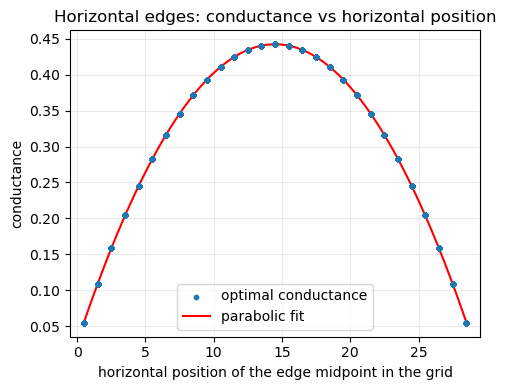

In [83]:
# Fit horizontal-edges vs horizontal-position with a parabola, overlay fit
# The fitting is flexible via a pluggable basis; swap basis_fns as desired.

import numpy as np
import matplotlib.pyplot as plt

# Ensure inputs exist from previous cells; rebuild if missing
if 'xh_hpos' not in globals() or 'wh' not in globals():
    # Need edges_horiz and net to rebuild
    if 'edges_horiz' not in globals():
        edges_all = list(net.edges())
        edges_horiz = [(u, v) for (u, v) in edges_all if (u // cols == v // cols) and (abs(u - v) == 1)]
    def _rc(n):
        return n // cols, n % cols
    xh_hpos, wh = [], []
    for (u, v) in edges_horiz:
        ru, cu = _rc(u); rv, cv = _rc(v)
        c = min(cu, cv)
        xh_hpos.append(c + 0.5)
        wh.append(net[u][v]['weight'])

x = np.asarray(xh_hpos, dtype=float)
y = np.asarray(wh, dtype=float)

# Flexible linear model fitting via basis functions
def create_polynomial_basis(degree=2):
    return [
        (lambda x, p=p: (x**p if p > 0 else np.ones_like(x))) for p in range(degree + 1)
    ]

def design_matrix(x, basis_fns):
    cols = [f(x) for f in basis_fns]
    return np.column_stack(cols) if cols else np.empty((x.shape[0], 0))

def fit_with_basis(x, y, basis_fns):
    X = design_matrix(x, basis_fns)
    coef, *_ = np.linalg.lstsq(X, y, rcond=None)
    return coef

def evaluate_basis(x, basis_fns, coef):
    X = design_matrix(x, basis_fns)
    return X @ coef

# Choose the model basis here (parabola by default).
# Swap to create_polynomial_basis(3) for cubic, or provide your own list of callables.
basis_fns = create_polynomial_basis(2)  # degree-2 parabola

fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(x, y, s=10, alpha=1, label='optimal conductance', zorder=10)

if x.size >= len(basis_fns):
    coef = fit_with_basis(x, y, basis_fns)
    xs = np.linspace(x.min(), x.max(), 400) if x.size else np.linspace(0, max(cols - 1, 1), 400)
    ys = evaluate_basis(xs, basis_fns, coef)
    label = 'parabolic fit'
    ax.plot(xs, ys, color='red', label=label)
    # Optional: display coefficients for a0 + a1 x + a2 x^2
    if len(coef) == 3:
        print(f'Quadratic coefficients: a0={coef[0]:.4g}, a1={coef[1]:.4g}, a2={coef[2]:.4g}')
else:
    print('Not enough data points to fit the chosen model.')


ax.set_title('Horizontal edges: conductance vs horizontal position')
ax.set_xlabel('horizontal position of the edge midpoint in the grid')
ax.set_ylabel('conductance')
ax.set_xlim(-0.5, cols - 0.5)
ax.grid(True, alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()
